In [1]:
import matplotlib.pyplot as plt
%matplotlib inline

# PDE Code Documentation 

This section of the documentation will discuss the Python implementation of Finite Element Method (FEM) solvers, using **cite** FEniCS.
It has been auto-generated by the Jupyter Notebook file `PDE_Doc.ipynb`. All citations are present in the main technical documentation document where this has been copied.

Code relating to generating PDE simulations is in the relevant subfolder of the code.

The notebook can be run by running each cell with code sequentially.


## Setting up PDE Code environment

This project uses the FEniCS computing platform which is more demanding to configure correctly than many other software dependencies. For this reason, we recommend using Docker to set up the environment. To do so, after installing Docker on your machine (see main website):

### Docker Setup

1. Navigate to the `PDEFEMCode` directory in Terminal/Command Prompt.
2. Build a docker image called `fenics_pdefem` using the `Dockerfile` in this directory using `docker build -t fenics_pdefem .` (The trailing period is important because it signifies the current directory.)

After running the commands, the necessary instructions to run FEniCS will have been downloaded on your machine. We have used with success, the Pycharm Professional Edition with student license, to interface with the docker container. However, for a quick run of the code, one can run:


1. *from the main project directory (in Linux, otherwise replace "$(pwd)" with the appropriate variable something else)*, run 

    `docker run -it --rm --it --rm -v "$(pwd)":/opt/project fenics_pdefem bash` 
    
    to run a docker container of the `fenics_pdefem` in interactive mode, which has the current directory mounted to `/opt/project`.
2. (Linux independent - we are in a container) In the running container, navigate to `/opt/project` by typing 
   
   `cd /opt/project`
3. Run the Single Gaussian Source simulation:
    
    `PYTHONPATH=. python3 PDEFEMCode/elliptic_ex.py -y PDEFEMCODE/Pickles/elliptic_params.yaml`


### Requirements.txt
There is also a requirements.txt file which contains all libraries that were used in this project. The key requirements are Python 3.6+, FEniCS=2019.1.0, pyyaml=5.4.1, dataclasses.


## Emission Field Simulation used in Optimization

This section contains brief instructions on how to generate the emission fileds used in the evaluation of optimization algorithm performance. Afterwards, how each script works will be broken down in detail.

### Commands to Generate Test Cases

The two elliptic (time-independent) emission fields were:
 - Elliptic Equation, Single Gaussian Source RHS: 
     - Generated by command `python elliptic_ex.py -y elliptic_params.yaml` 
     - Resulting pickle file saved to `elliptic_params.pkl`
 - Elliptic Equation, Multiple Gaussian Sources RHS:
     - Generated by command `python elliptic_ex.py -y elliptic_multi_gaussian.yaml` 
     - Resulting pickle file saved to `elliptic_multi_gaussian.pkl`
     
The two parabolic (time-dependent) emission fields were:
 - Parabolic Equation, Slow-moving Gaussian Source RHS:
     - Generated by command `python parabolic_ex.py -y par_moving_bump_slow.yaml` 
     - Resulting pickle file saved to `par_moving_bump_slow.pkl`
 - Parabolic Equation, Fast-moving Gaussian Source RHS:
     - Generated by command `python parabolic_ex.py -y par_moving_bump_fast.yaml` 
     - Resulting pickle file saved to `par_moving_bump_fast.pkl` 

 

## PDE Solver Files

This section goes into more detail about how the PDE solver files generate solutions. Each section shows key functions used to generate the source code and gives a motivating example.

Note: in this section, we break notation with the project description and use $u$ and $f$ to represent the function and source terms of the PDEs respectively. This keeps consistent with the FEniCS documentation. When the function is used again for external use
by using our custom interpolator, we change notation again to $f$ for the source term.
### Elliptical PDE Solver

We document the PDE solver by first showing some key functions used in it and then displaying a contour plot of its solution. 

#### Example Parameter File - Single Gaussian Point Source
Parameters describing how to run the elliptical solver are stored in the `EllipticRunParams` struct in `interface.py`. These parameters are stored in text form using the .YAML file format, and read in using the `PyYAML` library **insert citation**. 

The indentation in the following example parameter file corresponds to the `EllipticRunParams` struct that is generated. For instance, the struct determined by the yaml_file has sub-elements with names `var_form`, `rect_mesh`, and `io`.

As another example, the struct member P0 is accessed by `in_params.rect_mesh.P0`, given that the EllipticRunParams object is called `in_params`.

In [ ]:
%load PDEFEMCode/Pickles/elliptic_params.yaml

As we can see above, the mesh that the elliptic code uses is Friedrichs-Keller on rectangular mesh elements.


#### Key functionality of file: Source code 

To show the full functionality of the source code, we display the variational forms mentioned in the given parameter file (as well as the RHS expression generator) and then display the code which solves a variational equation.

In [ ]:
%load -s elliptic_LHS,elliptic_RHS,gaussian_expression_2D,setup_rectangular_function_space PDEFEMCode/fenics_utils.py


See the previous section Example Parameter file for a brief description of in_params.

In [ ]:
%load -s solve_single_variation_eq PDEFEMCode/elliptic_ex.py

#### Example: Using Custom Function Interpolators

In this short example, we load data from a previously generated pickle file to give an example plot of data

Text(0.5, 1.0, 'Gaussian Source function values.')

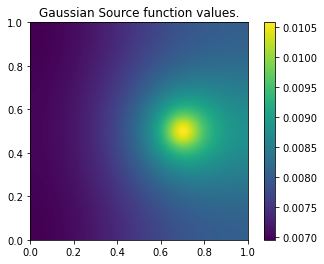

In [5]:
# # Code snippet to build intuition on the objects.

from PDEFEMCode.interface import pickle_load
import numpy as np

params = pickle_load('PDEFEMCode/Pickles/elliptic_params.pkl')
f, grad_f = params['f'], params['grad_f']
import matplotlib.pyplot as plt

n_interp = 200
x = y = np.linspace(0,1,n_interp)
coords = np.stack(np.meshgrid(x,y),axis = -1)
coords_rs = coords.reshape(-1,2)
f_eval = f(coords_rs).reshape(n_interp,n_interp)
plt.imshow(f_eval,
           extent=(x.min(),x.max(),y.min(),y.max()),origin='lower')
plt.colorbar()
plt.title('Gaussian Source function values.')


Text(0.5, 1.0, '$\\frac{\\partial}{\\partial x}$ of Gaussian Source.')

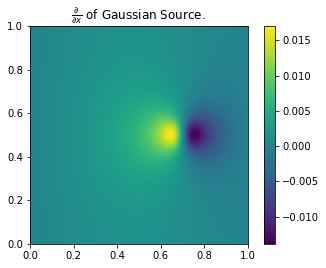

In [6]:
grad_f_eval = grad_f(coords) #grad_f(coords_rs) works fine too
plt.imshow(grad_f_eval[:,:,0],
           extent=(x.min(),x.max(),y.min(),y.max()),origin='lower')
plt.colorbar()
plt.title(r'$\frac{\partial}{\partial x}$ of Gaussian Source.')

### Parabolic PDE Solver

We document the parabolic PDE solver in an analogous way. First we show the parameters which determine how the parabolic server runs.

#### Example Parameter File - Slow-Moving Gaussian Point Source
Parameters describing how to run the elliptical solver are stored in the `ParabolicRunParams` struct in `interface.py`. As in the elliptical case, these parameters are stored in text form using the .YAML file format.

Just as before, the element P0 is accessed by `in_params.rect_mesh.P0`, given that the ParabolicRunParams object is called `in_params`.

In [ ]:
%load PDEFEMCode/Pickles/par_moving_bump_slow.yaml


#### Key functionality of file: Source code 

Just as before, we show the full functionality of the source code, we display the variational forms mentioned in the given parameter file (as well as the RHS expression generator) and then display the code which solves a variational equation. 
Note: 
 - The variational form of the heat equation was generated using the Implicit Euler method with time step `dt`, therefore requires `u_previous`, the solution at the previous timestep.
 - There is no function which generates a FEniCS expression string. This is because the full string is hard-coded in `var_form.rhs_expression_str` in the parameter file above.
 - A finite element solver is evaluated `time_disc.Nt` times after the initial time, where $u(0,x) = 0$ for all $x\in \Omega$.

In [ ]:
%load -s heat_eq_LHS,heat_eq_RHS PDEFEMCode/fenics_utils.py


In [ ]:
# %load -s solve_parabolic_problem PDEFEMCode/parabolic_ex.py


## Modularity of Code

The code is structured in such a way as to be modular. For this reason, functions are separated into two main files in the code:
 - `interface.py` contains external-facing functions that do not depend on FEniCS. 
    This includes definitions of the dataclass elements which define FEM runs, as well as the FEniCS interpolators.
 - `fenics_utils.py` contains functions which rely on fenics. 
    This includes helper functions that define variational forms and functions that set up the mesh environment.
    
PDE solvers are also written so that they need be run only the number of times that a simulation must be run.

## Unit Tests

The file `pde_test.py` contains automated unit tests that run quick numerical checks
on existing functions inside of the PDE libary. This helps give assurance that the
code still functions properly after e.g. a cosmetic change.

The tests are run before every big commit to the code, and include, among other things:
- numerical order of convergence tests for parabolic and elliptic code with analytical examples
- numerical tests on correct functionality of interpolator classes
- checks on pickle and YAML file loading

### Example: Order of Convergence Test with Plot

To give a little example of the elliptic code,
as well as to give examples of testing FEniCS code,
we give code which generates an Order of Convergence test
on the elliptical equation with right hand side function
\begin{equation*}
f = (2 \pi^2 +1)\sin(\pi x + \frac\pi 2)\sin(\pi y + \frac\pi2)
\end{equation*}

and analytical solution

\begin{equation*}
u_{\text{ref}} = \sin(\pi x + \frac\pi 2)\sin(\pi y + \frac\pi2)
\end{equation*}

The code has been adapted from a unit test in `pde_tests.py` to produce a plot.
To compute the order of convergence, we used the numerical order of convergence formila listed in **cite**.


Text(0.5, 1.0, 'Order of Convergence plot')

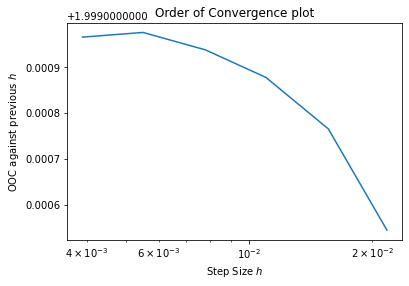

In [10]:
import fenics as fc
import PDEFEMCode.interface as pde_interface
import PDEFEMCode.fenics_utils as pde_utils
import numpy as np


#Strings defining the right hand side and analytical solution
RHS_fn_str = '(2*pi*pi + 1)*sin(pi*x[0] + pi/2)*sin(pi*x[1]+pi/2)'
u_ref_str = 'sin(pi*x[0] + pi/2)*sin(pi*x[1]+pi/2)'

#Define the inverse of the discretization parameter
n_list = np.asarray(np.ceil(np.logspace(5, 8, 7, base=2)),
                    dtype=np.int32)


#Define dummy rectangular mesh parameter on unit square
rmesh_p = pde_interface.RectMeshParams(nx=1,ny = 1, P0=[0,0],P1=[1,1])

#Define LHS and RHS forms.
LHS = pde_utils.elliptic_LHS
RHS = pde_utils.elliptic_RHS



error_L2_arr, error_LInf_arr = np.empty((2, 7))

#Perform tests on each discretization parameter
for ind,n_grid in enumerate(n_list):
    rmesh_p.nx = rmesh_p.ny = n_grid
    mesh, fn_space = pde_utils.setup_rectangular_function_space(rmesh_p)
    u_trial = fc.TrialFunction(fn_space)
    v_test = fc.TestFunction(fn_space)

    RHS_fn = fc.Expression(RHS_fn_str,
                               element=fn_space.ufl_element())
    u_ref = fc.Expression(u_ref_str,
                              element=fn_space.ufl_element())
    LHS_int, RHS_int = pde_utils.variational_formulation(
            u_trial, v_test,
            LHS,
            RHS, RHS_fn
        )
    u_sol = pde_utils.solve_vp(fn_space, LHS_int, RHS_int)

    error_L2_arr[ind] = pde_utils.error_L2(u_ref, u_sol)
    error_LInf_arr[ind] = pde_utils.error_LInf_piece_lin(u_ref, u_sol, mesh)

# Plot convergence results
h = 1./n_list.astype(np.float64)
OOC = (np.log(error_L2_arr[1:]) - np.log(error_L2_arr[:-1])) / \
              (np.log(h[1:]) - np.log(h[:-1]))

plt.semilogx(h[1:],OOC)
plt.xlabel('Step Size $h$')
plt.ylabel('OOC against previous $h$')
plt.title('Order of Convergence plot')

As the plot shows, as discretization parameter $h$ nears 0,
the order of convergence was measured to be within 0.001 of 2. Given that we are using degree 1 Lagrangian elements, this agrees with the expectation from  Thm 4.7 in  **cite**.